In [25]:
import glob
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import StratifiedKFold
from keras.layers import (Input, Dense, TimeDistributed, Activation, LSTM, GRU,
                          Dropout, merge, Reshape, Flatten, RepeatVector,
                          Conv1D, MaxPooling1D, SimpleRNN)
import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import keras_util as ku
from autoencoder import encoder
from survey_autoencoder import preprocess, main as survey_autoencoder
from light_curve import LightCurve

import re
import astropy.time
import datetime
import matplotlib.pyplot as plt

from keras.optimizers import Adam

In [23]:
lightcurves = pd.read_parquet("/data/object_lightcurves_small.parquet", )

In [26]:

def visit_to_mjd(visit):
    YEAR_POS = 100000000
    MONTH_POS = 1000000
    DAY_POS = 10000
    year = int(visit/YEAR_POS)
    month = int(visit/MONTH_POS % 100)
    decimal_day = visit/DAY_POS % 100
    hours = (decimal_day % 1) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    d = datetime.datetime(year, month, int(decimal_day), int(hours), int(minutes), int(seconds))
    time = astropy.time.Time(d)
    return time.mjd

    
    
# 2010 12 10 2874
print(visit_to_mjd(201012102874))


55540.28739583334


In [162]:
dir(lightcurves)

['T',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',


,obj_id,zone,ra,dec,mean_mag_best,source_id,visit,mag_best,magerr_best,flux_auto,fluxerr_auto,zeropoint,flags
336,653180794.0,65318.0,81.025663,0.718505,-9.909695,"[117189245486, 117188383933, 116995833376, 116...","[201001041612, 201001043812, 201001064031, 201...","[-10.3362, -9.95331, -9.34346, -9.92103, -10.0...","[0.0334161, 0.0601304, 0.10944, 0.0462239, 0.0...","[13629.4, 9579.08, 5462.38, 7901.79, 10300.7, ...","[419.375, 530.381, 550.464, 542.863, 733.915, ...","[27.0137, 26.9279, 26.2479, 26.7298, 26.9996, ...","[0, 2, 2, 3, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, ..."
816,653850194.0,65385.0,83.155472,0.811977,-6.855097,"[106731777399, 116980727393, 116982177132, 122...","[201012103102, 201001062795, 201001062887, 201...","[-6.58152, -6.58791, -6.37251, -7.19053, -7.04...","[0.215856, 0.228619, 0.358052, 0.176154, 0.216...","[429.151, 431.681, 354.0, 751.992, 658.169, 29...","[85.2989, 90.8752, 116.713, 121.976, 131.48, 8...","[27.2192, 27.1794, 27.1678, 27.3491, 27.3606, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1041,654220033.0,65422.0,81.827739,0.862759,-6.693480,"[106667538567, 106724377968, 106725658153, 106...","[201012093019, 201012102238, 201012102254, 201...","[-6.75249, -6.22626, -6.70479, -6.5003, -6.822...","[0.131102, 0.171059, 0.143105, 0.156177, 0.155...","[502.339, 309.387, 480.747, 398.215, 535.849, ...","[60.6425, 48.7325, 63.3493, 57.2671, 76.9181, ...","[26.9916, 27.117, 27.1179, 27.1293, 27.1317, 2...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1767,655430217.0,65543.0,81.333961,1.030588,-7.615596,"[106960417272, 137766385722, 137768766447, 123...","[201012142623, 201012122360, 201012124319, 200...","[-6.8158, -7.01273, -6.9943, -8.07612, -7.8252...","[0.198293, 0.170185, 0.237535, 0.133054, 0.133...","[532.502, 638.399, 748.882, 1700.0, 1349.25, 8...","[97.2298, 100.042, 125.509, 208.28, 165.798, 1...","[27.1431, 26.8713, 27.0766, 27.2273, 27.0866, ...","[0, 0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, ..."
2417,656380244.0,65638.0,83.394596,1.162546,-8.351905,"[117027895727, 117028025677, 117069555165, 123...","[201001051818, 201001052530, 201001042121, 200...","[-7.16515, -8.50185, -8.10889, -7.77874, -8.08...","[0.22506, 0.109598, 0.130066, 0.156699, 0.1275...","[734.615, 3476.96, 1752.09, 1292.69, 1712.95, ...","[152.24, 302.631, 209.841, 186.523, 201.199, 1...","[27.3284, 27.3777, 27.3841, 27.3477, 27.299, 2...","[0, 1, 0, 16, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,..."
3082,657230274.0,65723.0,81.696572,1.280689,-6.989178,"[106819374307, 117461304687, 123578444357, 124...","[201012113797, 201001093523, 200912154105, 200...","[-6.70683, -6.85889, -6.48874, -7.82554, -6.59...","[0.164995, 0.154909, 0.139651, 0.173602, 0.107...","[481.649, 554.06, 394.0, 1349.63, 433.532, 350...","[73.1766, 79.0322, 50.6651, 215.745, 42.8515, ...","[26.9287, 27.1519, 27.1836, 27.0698, 27.0464, ...","[24, 24, 24, 24, 24, 24, 24, 25, 24, 24, 24, 2..."
3319,657470067.0,65747.0,83.153924,1.315030,-10.938046,"[106680454470, 106733363405, 106733414245, 106...","[201012093233, 201012103342, 201012102488, 201...","[-11.0081, -10.6846, -11.0351, -10.7094, -10.9...","[0.00732744, 0.0107355, 0.0074955, 0.0101972, ...","[25306.2, 18786.0, 25943.1, 19220.4, 23060.6, ...","[170.745, 185.706, 179.058, 180.475, 174.515, ...","[27.1281, 27.2214, 27.2133, 26.9905, 27.0805, ...","[2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, ..."
3464,657630124.0,65763.0,82.993756,1.336491,-10.831264,"[106681824155, 106731374138, 106810263155, 106...","[201012093126, 201012102639, 201012112388, 201...","[-10.8269, -10.9133, -10.7435, -10.8009, -10.8...","[0.00925805, 0.00885768, 0.0123869, 0.0104927,...","[20581.7, 21968.1, 18695.0, 19861.0, 21474.6, ...","[157.26, 159.651, 189.216, 168.163, 197.642, 6...","[27.1115, 27.2157, 27.0124, 27.0707, 27.0474, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
3851,658090221.0,65809.0,83.202549,1.400560,-6.783778,"[117028383880, 116979793574, 106680423890, 117...","[201001052411, 20100106

In [ ]:
lightcurves.where(lightcurves['flux_auto'].map(len) >= 200)

In [166]:
lightcurve_objects = []

lc_stds = lightcurves['flux_auto'].where(lightcurves['flux_auto'].map(len) >= 200).map(lambda x: np.std(x)/np.mean(x))
for id, lc in lightcurves.where(lc_stds > 0.4).dropna().head(400).iterrows():
    
    if(len(lc['mag_best']) != len(lc['zeropoint'])):
        # This is weird and should not be in the database, but somehow it is
        continue
        
    calib_mag = lc['mag_best'] + lc['zeropoint']
    sel, = np.where(calib_mag < 50)
    lightcurve = LightCurve(np.array([visit_to_mjd(visit) for visit in lc['visit'][sel]]),
                            calib_mag[sel], lc['magerr_best'][sel])
    lightcurve_objects.append(lightcurve)
    
len(lightcurve_objects)

301

In [126]:

def setup_model(input_args, classes, input_shape):

    args = ku.parse_model_args(input_args)

    args.loss = 'categorical_crossentropy'
    model_type_dict = {'gru': GRU, 'lstm': LSTM, 'vanilla': SimpleRNN,
                           'conv': Conv1D}#, 'atrous': AtrousConv1D, 'phased': PhasedLSTM}


    model_input = Input(shape=(input_shape[1], input_shape[-1]), name='main_input')
    encode = encoder(model_input, layer=model_type_dict[args.model_type],
                     output_size=args.embedding, **vars(args))

    scale_param_input = Input(shape=(2,), name='scale_params')
    merged = merge([encode, scale_param_input], mode='concat')

    out = Dense(args.size + 2, activation='relu')(merged)
    out = Dense(len(classes), activation='softmax')(out)
    model = Model([model_input, scale_param_input], out)

    run = ku.get_run_id(**vars(args))
    if args.pretrain:
        for layer in model.layers:
            layer.trainable = False
        pretrain_weights = os.path.join('keras_logs', 
                                        args.pretrain, run, 'weights.h5')
    else:
        pretrain_weights = None

    optimizer = Adam(lr=args.lr)
    model.compile(optimizer=optimizer, loss=args.loss, metrics=['accuracy'],
                      sample_weight_mode='temporal')
    model.load_weights(pretrain_weights, by_name=True)
    
    return model
 

In [127]:
#linear/n200/gru_096_x2_1m03_drop25_emb64_bidir
input_args = {"pretrain": "linear/n200",
        "model_type": "gru",
        "size": 96,
        "num_layers": 2,
        "lr": 0.001,
        "drop_frac": 0.25,
        "embedding": 64,
        "sim_type": "linear",
        "bidirectional": True,
        "m_max": 24.0,
       }
classes = ['RR_Lyrae_FM', 'W_Ursae_Maj', 'Classical_Cepheid',
               'Beta_Persei', 'Semireg_PV']

input_shape = (1, 200, 2)

model = setup_model(input_args, classes, input_shape)

/home/centos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  app.launch_new_instance()
/home/centos/miniconda3/lib/python3.6/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [167]:
out_classifications = np.zeros((len(lightcurve_objects), len(classes)))

for n, lightcurve in enumerate(lightcurve_objects):
    X_list = [np.c_[lc.times, lc.measurements, lc.errors] for lc in lightcurve.split(args.n_min, args.n_max)]

    if(len(X_list) == 0):
        continue
    X_raw = pad_sequences(X_list, value=np.nan,
                      dtype='float', padding='post')

    X, means, scales, wrong_units = preprocess(X_raw, args.m_max)
    out = model.predict([X, np.c_[means, scales]])
    out_classifications[n,:] = np.nanmean(out, axis=0)

/home/centos/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


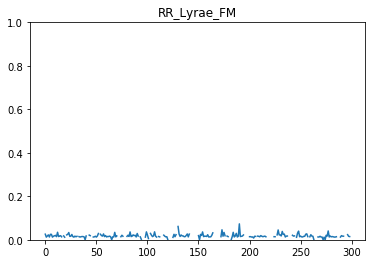

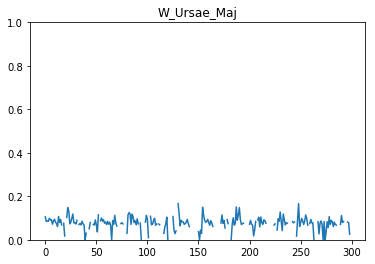

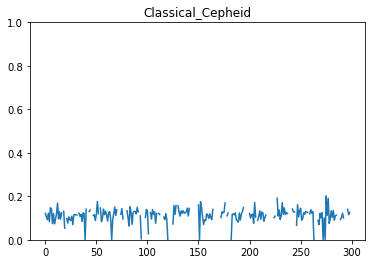

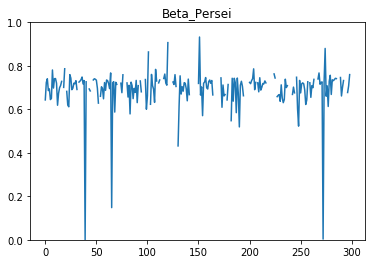

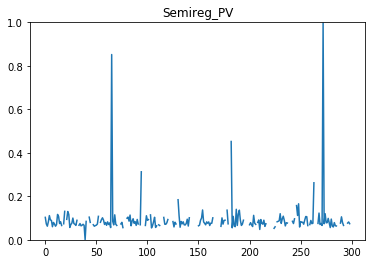

In [168]:
for n in range(0, 5):
    plt.plot(out_classifications[:, n])
    plt.title(classes[n])
    plt.ylim(0, 1)
    plt.show()

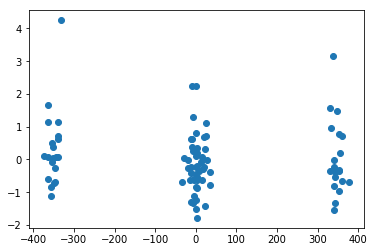

In [82]:

lc_n = 4

plt.plot(X[lc_n,:,0], X[lc_n,:,1], 'o')